In [2]:
!pip install lightgbm

In [5]:
%load_ext autoreload
%autoreload 1
%aimport transformations

from pathlib import Path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler, PowerTransformer

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

RS = 35577 # global random state seed
raw_data_dir_path = './data-raw'

data_csv_path = f'{raw_data_dir_path}/bearing_signals.csv'
lbls_csv_path = f'{raw_data_dir_path}/bearing_classes.csv'

%aimport transformations
%aimport f

df_data = pd.read_csv(data_csv_path)
df_lbls = pd.read_csv(lbls_csv_path, sep=';', index_col = 'bearing_id')

df_data = pd.merge(df_data, df_lbls, left_on='bearing_2_id', right_on='bearing_id')

df_data = transformations.drop_rpm_outliers(df_data)
df_data = transformations.drop_w_outliers(df_data)
df_data = transformations.drop_idle_rpm(df_data)
df_data = df_data.drop('hz', axis=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
df_data.head()
df_data.columns

,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,w,status
4912,1,0,1,1.637333,-0.271517,0.244341,-0.302339,0.285992,0.194450,0.255007,36.644951,0.078311,0
4913,1,0,1,1.637667,-0.079124,0.149706,-0.206307,0.002779,0.194450,0.354653,36.644951,0.028275,0
4914,1,0,1,1.638000,-0.175320,-0.228832,-0.110275,0.285992,0.290562,-0.243222,36.644951,0.013856,0
4915,1,0,1,1.638333,-0.271517,0.244341,0.177821,0.002779,-0.093886,-0.043930,36.644951,0.335106,0
4916,1,0,1,1.638667,-0.175320,-0.323466,-0.206307,0.285992,0.386674,-0.143576,36.644951,1.679266,0


Index(['experiment_id', 'bearing_1_id', 'bearing_2_id', 'timestamp', 'a1_x',
       'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w', 'status'],
      dtype='object')

In [15]:
def q1(arr):
    return np.quantile(arr, 0.25)

def q3(arr):
    return np.quantile(arr, 0.75)

def iqr(arr):
    return q3(arr)-q1(arr)

def kurtosis(series):
    return series.kurtosis()

In [31]:
b1 = df_data.groupby(['experiment_id'])[['a1_x', 'a1_y', 'a1_z']].agg([np.min, np.max, np.sum, np.median, np.mean, np.std, np.var, q1, q3, iqr, kurtosis])

In [42]:
b1 = df_data.groupby(['experiment_id'])[['a1_x', 'a1_y', 'a1_z']].agg([np.min, np.max, np.sum, np.median, np.mean, np.std, np.var, q1, q3, iqr, kurtosis])
b1.columns = ['__'.join(col).strip() for col in b1.columns.values]
b1.columns = [col[3:] for col in b1.columns]


b1['status'] = 1
b1.head(3)
b1.shape

,x__amin,x__amax,x__sum,x__median,x__mean,x__std,x__var,x__q1,x__q3,x__iqr,x__kurtosis,y__amin,y__amax,y__sum,y__median,y__mean,y__std,y__var,y__q1,y__q3,y__iqr,y__kurtosis,z__amin,z__amax,z__sum,z__median,z__mean,z__std,z__var,z__q1,z__q3,z__iqr,z__kurtosis,status
experiment_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-9.410165,7.327991,-14639.636820,-0.17532,-0.182339,1.800587,3.242115,-1.233480,0.882839,2.116318,0.587040,-4.298115,5.638507,-238.296045,-0.039563,-0.002968,1.106395,1.224109,-0.702004,0.622879,1.324883,0.388498,-8.657115,9.204820,-2461.408418,-0.014243,-0.030657,1.739719,3.026622,-0.878530,1.042108,1.920638,1.172709,1
2,-7.582435,7.424187,-15040.326263,-0.17532,-0.175244,1.573574,2.476136,-1.041087,0.690446,1.731533,0.890521,-4.676653,4.881431,-674.067930,0.055072,-0.007854,0.952555,0.907360,-0.512735,0.528244,1.040979,0.759756,-8.080924,8.340533,-4447.178928,-0.014243,-0.051817,1.560769,2.435999,-0.878530,0.850044,1.728574,0.829349,1
3,-8.352005,7.231794,-13269.832546,-0.17532,-0.175061,1.669721,2.787967,-1.137283,0.882839,2.020122,0.579469,-4.108846,5.449238,-207.461501,0.055072,-0.002737,1.033300,1.067709,-0.607370,0.622879,1.230248,0.435472,-8.369019,8.052437,-2744.846340,-0.014243,-0.036211,1.621235,2.628405,-0.974562,0.946076,1.920638,0.589342,1


(112, 34)

In [44]:
b2 = df_data.groupby(['experiment_id'])[['a2_x', 'a2_y', 'a2_z']].agg([np.min, np.max, np.sum, np.median, np.mean, np.std, np.var, q1, q3, iqr, kurtosis])
b2.columns = ['__'.join(col).strip() for col in b2.columns.values]
b2.columns = [col[3:] for col in b2.columns]

b2 = pd.merge(b2, df_lbls, left_on='experiment_id', right_index=True)
b2.head(3)
b2.shape

,x__amin,x__amax,x__sum,x__median,x__mean,x__std,x__var,x__q1,x__q3,x__iqr,x__kurtosis,y__amin,y__amax,y__sum,y__median,y__mean,y__std,y__var,y__q1,y__q3,y__iqr,y__kurtosis,z__amin,z__amax,z__sum,z__median,z__mean,z__std,z__var,z__q1,z__q3,z__iqr,z__kurtosis,status
experiment_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-10.004077,8.687975,9028.584201,0.097183,0.112452,2.524144,6.371301,-1.696498,1.890865,3.587363,-0.366768,-8.647843,9.228967,1795.731880,0.002226,0.022366,2.310334,5.337641,-1.535564,1.636128,3.171692,0.043743,-10.207810,11.813929,20418.716468,0.255007,0.254318,2.054914,4.222673,-0.940743,1.450758,2.391501,0.666557,0
2,-9.437651,8.310358,-15382.575480,-0.091625,-0.179232,2.210734,4.887344,-1.696498,1.324439,3.020938,-0.146052,-7.975060,8.748408,2141.374940,0.194450,0.024950,2.101804,4.417581,-1.343340,1.443905,2.787245,0.308751,-11.104623,8.924198,16750.047234,0.155361,0.195165,1.697682,2.882124,-0.741452,1.151820,1.893272,1.245151,0
3,-12.080972,9.632018,-9291.333729,-0.091625,-0.122575,2.473349,6.117454,-1.885307,1.702056,3.587363,-0.305633,-8.455619,10.190086,2723.506094,0.194450,0.035930,2.336275,5.458180,-1.439452,1.636128,3.075580,0.222866,-11.204268,7.927740,14134.266597,0.155361,0.186465,1.787246,3.194247,-0.940743,1.251466,2.192209,0.701376,0


(112, 34)

In [45]:
b_all = pd.concat([b1,b2], axis=0, ignore_index=True)

In [47]:
b_all['status'].value_counts()

1    124
0    100
Name: status, dtype: int64

In [67]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from lightgbm import LGBMClassifier

In [54]:
X = b_all.drop('status', axis=1)
y = b_all['status']

In [56]:
model = LGBMClassifier(random_state=RS)
cross_val_score(model, X, y, cv = 8)

array([0.96428571, 0.92857143, 0.89285714, 0.96428571, 1.        ,
       0.85714286, 1.        , 0.78571429])

In [133]:
def cross_val(model_factory, X, y, models = None):
    scores = []
    np.random.seed(RS)
    
    for rs in range(20):
        for i_fold, (idx_train, idx_test) in enumerate(StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random.randint(0,1000000)).split(X, y, y)):
            X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
            X_test, y_test = X.iloc[idx_test], y.iloc[idx_test]

            for _ in range(5):
                model = model_factory(np.random.randint(0,1000000))
                model.fit(X_train, y_train)

                y_pred = model.predict_proba(X_test)[:, 1]
                score = roc_auc_score(y_test, y_pred)
                scores.append(score)

                if models is not None:
                    models.append(model)

    return np.array(scores)

In [134]:
%%timeit
lgbt_factory = lambda rs : LGBMClassifier(random_state=rs)

models = []
scores = cross_val(lgbt_factory, X, y, models)

23.2 s ± 4.11 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [140]:
len(scores)

1000

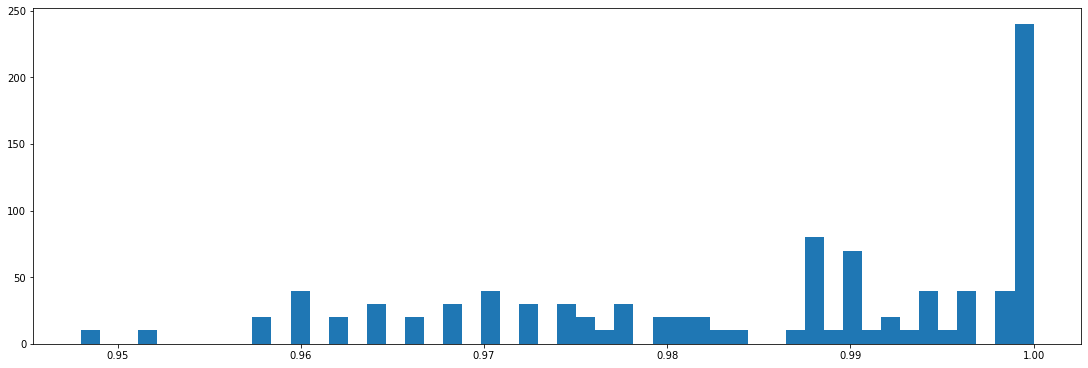

In [143]:
_ = f.get_ax(aspect=3).hist(scores, bins=50)